In [125]:
import sys
sys.path.append('/Users/yuhu/Desktop/p4-Speech/Speech-Speaker-Recognition/lab1')
sys.path.append('/Users/yuhu/Desktop/p4-Speech/Speech-Speaker-Recognition/lab2')
from lab1_proto import *
from lab2_proto import *
from tqdm import trange
import os
import numpy as np 
import re
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import one_hot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from itertools import groupby
import editdistance

In [124]:
pip install editdistance

     |████████████████████████████████| 43 kB 3.8 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [92]:
phoneHMMs_all = np.load('/Users/yuhu/Desktop/p4-Speech/Speech-Speaker-Recognition/lab2/lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs_all.keys())
nstates = {phone: phoneHMMs_all[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(i) for ph in phones for i in range(nstates[ph])]
print(phones)
print(stateList)

['ah', 'ao', 'ay', 'eh', 'ey', 'f', 'ih', 'iy', 'k', 'n', 'ow', 'r', 's', 'sil', 'sp', 't', 'th', 'uw', 'v', 'w', 'z']
['ah_0', 'ah_1', 'ah_2', 'ao_0', 'ao_1', 'ao_2', 'ay_0', 'ay_1', 'ay_2', 'eh_0', 'eh_1', 'eh_2', 'ey_0', 'ey_1', 'ey_2', 'f_0', 'f_1', 'f_2', 'ih_0', 'ih_1', 'ih_2', 'iy_0', 'iy_1', 'iy_2', 'k_0', 'k_1', 'k_2', 'n_0', 'n_1', 'n_2', 'ow_0', 'ow_1', 'ow_2', 'r_0', 'r_1', 'r_2', 's_0', 's_1', 's_2', 'sil_0', 'sil_1', 'sil_2', 'sp_0', 't_0', 't_1', 't_2', 'th_0', 'th_1', 'th_2', 'uw_0', 'uw_1', 'uw_2', 'v_0', 'v_1', 'v_2', 'w_0', 'w_1', 'w_2', 'z_0', 'z_1', 'z_2']


In [3]:
traindata=np.load('train_nondynamic.npz',allow_pickle=1)
X_train_lmfcc = traindata['lmfcc'].astype('float32')
X_train_mspec = traindata['mspec'].astype('float32')
Y_train = traindata['Y']
Y_train = np.squeeze(one_hot(Y_train,len(stateList)))

valdata=np.load('val_nondynamic.npz',allow_pickle=1)
X_val_lmfcc = valdata['lmfcc'].astype('float32')
X_val_mspec = valdata['mspec'].astype('float32')
Y_val = valdata['Y']
Y_val = np.squeeze(one_hot(Y_val,len(stateList)))

testdata=np.load('test_nondynamic.npz',allow_pickle=1)
X_test_lmfcc = testdata['lmfcc'].astype('float32')
X_test_mspec = testdata['mspec'].astype('float32')
Y_test = testdata['Y']
Y_test = np.squeeze(one_hot(Y_test,len(stateList)))

traindata_d=np.load('train_dynamic.npz',allow_pickle=1)
X_train_lmfcc_d = traindata_d['lmfcc'].astype('float32')
X_train_mspec_d = traindata_d['mspec'].astype('float32')
Y_train_d = traindata_d['Y']
Y_train_d = np.squeeze(one_hot(Y_train_d,len(stateList)))

valdata_d=np.load('val_dynamic.npz',allow_pickle=1)
X_val_lmfcc_d = valdata_d['lmfcc'].astype('float32')
X_val_mspec_d = valdata_d['mspec'].astype('float32')
Y_val_d = valdata_d['Y']
Y_val_d = np.squeeze(one_hot(Y_val_d,len(stateList)))

testdata_d=np.load('test_dynamic.npz',allow_pickle=1)
X_test_lmfcc_d = testdata_d['lmfcc'].astype('float32')
X_test_mspec_d = testdata_d['mspec'].astype('float32')
Y_test_d = testdata_d['Y']
Y_test_d = np.squeeze(one_hot(Y_test_d,len(stateList)))

In [4]:
def normalize(X_train,X_val,X_test): 
  mean = np.mean(X_train,axis=0,keepdims=1)
  std = np.std(X_train,axis=0,keepdims=1)
  return (X_train-mean)/std,(X_val-mean)/std,(X_test-mean)/std

In [5]:
# non-dynamic
X_train_lmfcc,X_val_lmfcc,X_test_lmfcc=normalize(X_train_lmfcc,X_val_lmfcc,X_test_lmfcc)
X_train_mspec,X_val_mspec,X_test_mspec=normalize(X_train_mspec,X_val_mspec,X_test_mspec)
# dynamic
X_train_lmfcc_d,X_val_lmfcc_d,X_test_lmfcc_d=normalize(X_train_lmfcc_d,X_val_lmfcc_d,X_test_lmfcc_d)
X_train_mspec_d,X_val_mspec_d,X_test_mspec_d=normalize(X_train_mspec_d,X_val_mspec_d,X_test_mspec_d)


In [6]:
def get_model(input_shape,n_states):
  Inp = Input(input_shape)
  x = Dense(256,activation='relu')(Inp)
  x = Dense(256,activation='relu')(x)
  x = Dense(256,activation='relu')(x)
  y = Dense(n_states,activation='softmax')(x)
  model = Model(inputs=Inp,outputs=y)
  print(model.summary())
  return model

In [106]:
model_lmfcc = get_model(X_train_lmfcc[-1].shape,len(stateList))
model_lmfcc.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               3584      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 61)                15677     
Total params: 150,845
Trainable params: 150,845
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
his_lmffc = model_lmfcc.fit(X_train_lmfcc,Y_train,validation_data = (X_val_lmfcc,Y_val),batch_size=256,epochs=20)

Train on 1354743 samples, validate on 152314 samples
Epoch 1/20
1354743/1354743 [==============================] - 14s 11us/sample - loss: 1.5339 - accuracy: 0.5316 - val_loss: 1.5792 - val_accuracy: 0.5200
Epoch 2/20
1354743/1354743 [==============================] - 13s 10us/sample - loss: 1.5158 - accuracy: 0.5362 - val_loss: 1.5725 - val_accuracy: 0.5223
Epoch 3/20
1354743/1354743 [==============================] - 16s 12us/sample - loss: 1.5012 - accuracy: 0.5400 - val_loss: 1.5727 - val_accuracy: 0.5214
Epoch 4/20
1354743/1354743 [==============================] - 21s 16us/sample - loss: 1.4894 - accuracy: 0.5430 - val_loss: 1.5652 - val_accuracy: 0.5244
Epoch 5/20
1354743/1354743 [==============================] - 21s 15us/sample - loss: 1.4794 - accuracy: 0.5455 - val_loss: 1.5683 - val_accuracy: 0.5239
Epoch 6/20
1354743/1354743 [==============================] - 17s 13us/sample - loss: 1.4707 - accuracy: 0.5480 - val_loss: 1.5689 - val_accuracy: 0.5243
Epoch 7/20
1354743/1354

In [110]:
model_lmfcc.save("model_lmfcc.h5")

In [7]:
model_lmfcc_d = get_model(X_train_lmfcc_d[-1].shape,len(stateList))
model_lmfcc_d.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               23552     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 61)                15677     
Total params: 170,813
Trainable params: 170,813
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
his_lmffc_d = model_lmfcc_d.fit(X_train_lmfcc_d,Y_train_d,batch_size=256,epochs=20)

Train on 1354743 samples
Epoch 1/20
1354743/1354743 [==============================] - 15s 11us/sample - loss: 0.7867 - accuracy: 0.7415
Epoch 2/20
1354743/1354743 [==============================] - 14s 10us/sample - loss: 0.6200 - accuracy: 0.7890
Epoch 3/20
1354743/1354743 [==============================] - 14s 10us/sample - loss: 0.5673 - accuracy: 0.8046
Epoch 4/20
1354743/1354743 [==============================] - 16s 12us/sample - loss: 0.5395 - accuracy: 0.8138
Epoch 5/20
1354743/1354743 [==============================] - 27s 20us/sample - loss: 0.5201 - accuracy: 0.8197
Epoch 6/20
1354743/1354743 [==============================] - 19s 14us/sample - loss: 0.5055 - accuracy: 0.8245
Epoch 7/20
1354743/1354743 [==============================] - 16s 12us/sample - loss: 0.4938 - accuracy: 0.8279
Epoch 8/20
1354743/1354743 [==============================] - 16s 12us/sample - loss: 0.4840 - accuracy: 0.8309
Epoch 9/20
1354743/1354743 [==============================] - 17s 12us/sample -

In [10]:
model_lmfcc_d.save("model_lmfcc_d.h5")

In [111]:
model_mspec = get_model(X_train_mspec[-1].shape,len(stateList))
model_mspec.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               10496     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 61)                15677     
Total params: 157,757
Trainable params: 157,757
Non-trainable params: 0
_________________________________________________________________
None


In [112]:
his_mspec = model_mspec.fit(X_train_mspec,Y_train,batch_size=256,epochs=20)


Train on 1354743 samples
Epoch 1/20
1354743/1354743 [==============================] - 14s 11us/sample - loss: 1.7307 - accuracy: 0.4882
Epoch 2/20
1354743/1354743 [==============================] - 15s 11us/sample - loss: 1.5581 - accuracy: 0.5266
Epoch 3/20
1354743/1354743 [==============================] - 14s 11us/sample - loss: 1.5000 - accuracy: 0.5406
Epoch 4/20
1354743/1354743 [==============================] - 14s 11us/sample - loss: 1.4643 - accuracy: 0.5495
Epoch 5/20
1354743/1354743 [==============================] - 15s 11us/sample - loss: 1.4389 - accuracy: 0.5561
Epoch 6/20
1354743/1354743 [==============================] - 15s 11us/sample - loss: 1.4190 - accuracy: 0.5615
Epoch 7/20
1354743/1354743 [==============================] - 15s 11us/sample - loss: 1.4028 - accuracy: 0.5654
Epoch 8/20
1354743/1354743 [==============================] - 15s 11us/sample - loss: 1.3904 - accuracy: 0.5687
Epoch 9/20
1354743/1354743 [==============================] - 15s 11us/sample -

In [113]:
model_mspec.save("model_mspec.h5")


In [114]:
model_mspec_d = get_model(X_train_mspec_d[-1].shape,len(stateList))
model_mspec_d.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 280)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               71936     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 61)                15677     
Total params: 219,197
Trainable params: 219,197
Non-trainable params: 0
_________________________________________________________________
None


In [115]:
his_mspec_d = model_mspec_d.fit(X_train_mspec_d,Y_train,batch_size=256,epochs=20)


Train on 1354743 samples
Epoch 1/20
1354743/1354743 [==============================] - 19s 14us/sample - loss: 0.9101 - accuracy: 0.7039
Epoch 2/20
1354743/1354743 [==============================] - 18s 13us/sample - loss: 0.7364 - accuracy: 0.7532
Epoch 3/20
1354743/1354743 [==============================] - 18s 13us/sample - loss: 0.6873 - accuracy: 0.7678
Epoch 4/20
1354743/1354743 [==============================] - 18s 13us/sample - loss: 0.6588 - accuracy: 0.7762
Epoch 5/20
1354743/1354743 [==============================] - 19s 14us/sample - loss: 0.6383 - accuracy: 0.7825
Epoch 6/20
1354743/1354743 [==============================] - 19s 14us/sample - loss: 0.6230 - accuracy: 0.7873
Epoch 7/20
1354743/1354743 [==============================] - 17s 13us/sample - loss: 0.6094 - accuracy: 0.7916
Epoch 8/20
1354743/1354743 [==============================] - 19s 14us/sample - loss: 0.5999 - accuracy: 0.7944
Epoch 9/20
1354743/1354743 [==============================] - 20s 15us/sample -

In [116]:
model_mspec_d.save("model_mspec_d.h5")

In [117]:
model_lmfcc = load_model('model_lmfcc.h5')
model_lmfcc_d = load_model('model_lmfcc_d.h5')
model_mspec = load_model('model_mspec.h5')
model_mspec_d = load_model('model_mspec_d.h5')


In [52]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 5)
def plot_posteriors(model,X,y):
  Y_hat=model.predict(X)
#   Y=np_utils.to_categorical(y,len(stateList))
  sns.heatmap(Y_hat.T,cmap='Blues',yticklabels=stateList)
  plt.title("Posteriors")
  plt.show()
  sns.heatmap(y.T,cmap='Blues',yticklabels=stateList)
  plt.title("Label")
  plt.show()

Populating the interactive namespace from numpy and matplotlib


In [53]:
print(X_test_lmfcc_d[:178].shape,Y_test_d[:178].shape)
print(model_lmfcc_d.predict(X_test_lmfcc_d[:178]).shape)
print(np_utils.to_categorical(Y_test_d[:178],len(stateList)).shape)

(178, 91) (178, 61)
(178, 61)
(178, 61, 61)


lmfcc_dynamic


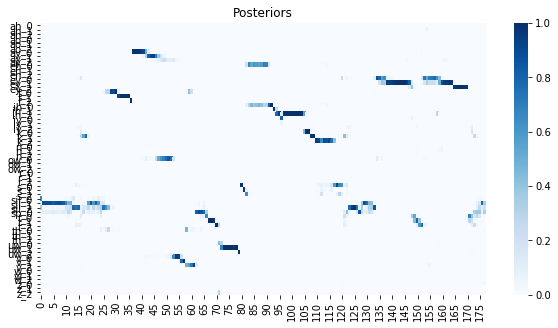

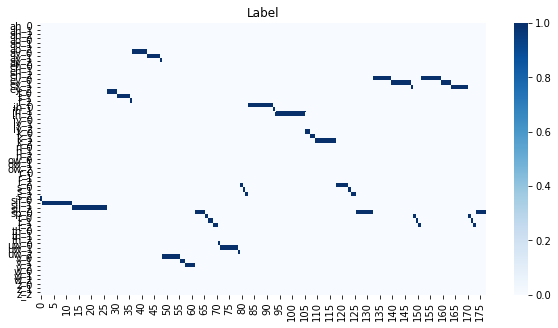

In [54]:
print('lmfcc_dynamic')
plot_posteriors(model_lmfcc_d,X_test_lmfcc_d[:178],Y_test_d[:178])

## Detailed Evaluation

### Frame-by-frame at the state level

In [55]:
def CountStateFrame(model,X,y,cm=1):
  y_hat=np.argmax(model.predict(X),axis=1)
  if cm:
    cm = confusion_matrix(np.array(stateList)[y],np.array(stateList)[y_hat],np.array(stateList),normalize='true')
    sns.heatmap(cm,cmap='Blues',xticklabels=stateList,yticklabels=stateList)
    plt.title("frame-by-frame at the state level ")
    plt.show()
  return np.sum(y_hat==y)/len(y)

lmfcc_dynamic


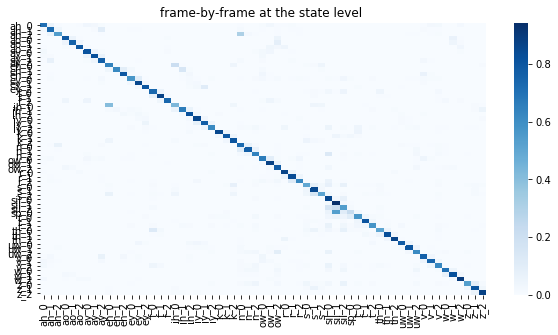

In [67]:
print('lmfcc_dynamic')
y_test_d = np_utils.to_categorical(Y_test_d,len(stateList))
print(CountStateFrame(model_lmfcc_d,X_test_lmfcc_d,testdata_d['Y']))

In [119]:
Y_test_d=testdata_d['Y']
print(list(Y_test_d[1]))
Y_test_d[1] = list(Y_test_d[1])
Y=np_utils.to_categorical(Y_test_d,len(stateList))
# print(Y)
# np.array(stateList)[Y_test_d[80]]
# stateList[0][:-2]
# np.array(stateList)[Y_test_d].shape
a = np.array([np.array(stateList)[int(Y_test_d[i])][:-2] for i in range(X_test_lmfcc_d.shape[0])])
# print(np.array(stateList))
# a =np.array(stateList)[int(Y_test_d[1])][:-2]
print(a)

[40]
['sil' 'sil' 'sil' ... 'sil' 'sil' 'sil']


In [98]:
print(a[0:4])
print(np.array(phones[0:4])) 


['sil' 'sil' 'sil' 'sil']
['ah' 'ao' 'ay' 'eh']


In [101]:
def CountPhoneme(model,X,y,cm=1):
  y_hat=np.argmax(model.predict(X),axis=1)
  y=np.array([np.array(stateList)[int(y[i])][:-2] for i in range(X.shape[0])])
  y_hat=np.array([np.array(stateList)[int(y_hat[i])][:-2] for i in range(X.shape[0])])

  if cm:
    cm = confusion_matrix(y,y_hat,np.array(phones),normalize='true')
    sns.heatmap(cm,cmap='Blues',xticklabels=phones,yticklabels=phones)
    plt.title("frame-by-frame at the phoneme level")
    plt.show()
  return sum([1 for i in range(X.shape[0]) if y[i]==y_hat[i]])/len(y)

Populating the interactive namespace from numpy and matplotlib
lmfcc_dynamic


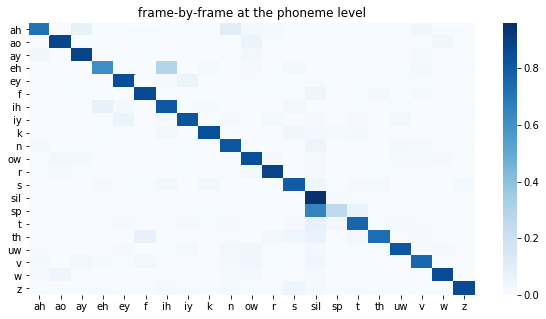

0.8542152196724662


In [103]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 5)
print('lmfcc_dynamic')
print(CountPhoneme(model_lmfcc_d,X_test_lmfcc_d,testdata_d['Y']))

In [170]:
def PER(model,X,y):
 y_hat=np.argmax(model.predict(X),axis=1)
 r=0
 n=X.shape[0]//178
 p=0
 for i in range(n):
  y_hat_merged = [int(j) for j,g in groupby(y_hat[p:p+178])]
  y_merged = [int(j) for j,g in groupby(y[p:p+178])]
#   print(y_hat_merged,y_merged)
  r+=editdistance.eval(y_hat_merged,y_merged)
  p+=178
 return r/n

In [171]:
print(Y_test_d[0:5])
# print(int(Y_test_d[0]))
y = Y_test_d
y_merged = [int(j) for j,g in groupby(y[0:5])]
print(y_merged)
# c=editdistance.eval([1 2],[3 4])

[[39]
 [40]
 [40]
 [40]
 [40]]
[39, 40]


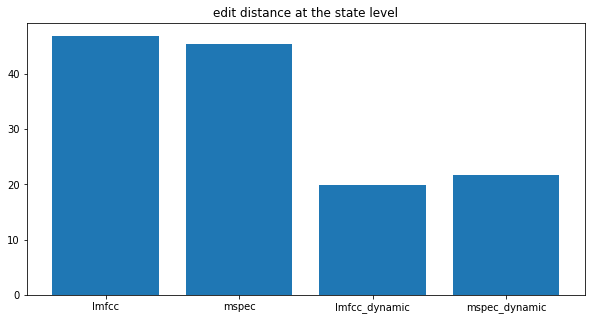

In [172]:
dis=np.zeros(4)
label=['lmfcc','mspec','lmfcc_dynamic','mspec_dynamic']
dis[0]=PER(model_lmfcc,X_test_lmfcc,Y_test_d)
dis[1]=PER(model_mspec,X_test_mspec,Y_test_d)
dis[2]=PER(model_lmfcc_d,X_test_lmfcc_d,Y_test_d)
dis[3]=PER(model_mspec_d,X_test_mspec_d,Y_test_d)
plt.title('edit distance at the state level')
plt.bar(label,dis)
plt.show()

In [185]:
def PER_P(model,X,y):
 y_hat=np.argmax(model.predict(X),axis=1)
 r=0
 n=X.shape[0]//178
 p=0
 for j in range(n):
  y_hat_merged = [i for i,g in groupby(y_hat[p:p+178])]
  tmp = [np.array(stateList)[int(y_hat_merged[i])][:-2] for i in range(len(y_hat_merged))]
  y_hat_merged = [j for j,g in groupby(tmp)]
  # c=editdistance.eval([1int(j) for i,g in groupby(tmp)]
  y_merged = [i for i,g in groupby(y[p:p+178])]
  tmp = [np.array(stateList)[int(y_merged[i])][:-2] for i in range(len(y_merged))]
  y_merged = [i for i,g in groupby(tmp)]
  p+=178
  r+=editdistance.eval(y_hat_merged,y_merged)
 return r/n

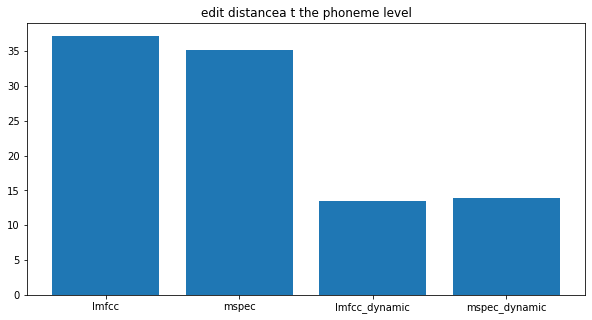

In [186]:
dis[0]=PER_P(model_lmfcc,X_test_lmfcc,Y_test_d)
dis[1]=PER_P(model_mspec,X_test_mspec,Y_test_d)
dis[2]=PER_P(model_lmfcc_d,X_test_lmfcc_d,Y_test_d)
dis[3]=PER_P(model_mspec_d,X_test_mspec_d,Y_test_d)
plt.title('edit distancea t the phoneme level')
plt.bar(label,dis)
plt.show()

## Questions
### 1.What is the influnce of feature kind and size of input context window?
（lmfcc is faster than mspec and lmfcc has better performance than mepec）
(transition between states improves accuracy)

### 2. what is the purpose of nomalising the input feature vectors depending on the activation functions in the network?
()

### 3. what is the influnce of the number of units per layer and the number of layers?
(It influnces the complexity of network,it's a bias-variance problem, the choice of parameters setting depends on the problem and dataset)

### 4. what is the influnce of the activation function ?


### 5. what is the influnce of learning rate?
(It decides the converge speed and stability of training process)

### 6. how stable are the posteriograms from the network in time?
(it's stable)

### 7.How do the errors distribute depending on the phonetic class?
